In [ ]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

In [ ]:
# Define tools


@tool
def add_numbers(x: float, y: float) -> float:
    """
    Adds two floating-point numbers and returns their sum.

    Args:
        x (float): The first number.
        y (float): The second number.

    Returns:
        float: The sum of x and y.
    """
    return x + y


@tool
def multiply_numbers(x: float, y: float) -> float:
    """
    Multiplies two floating-point numbers and returns the product.

    Args:
        x (float): The first number.
        y (float): The second number.

    Returns:
        float: The product of x and y.
    """
    return x * y


@tool
def web_search(query: str) -> dict:
    """
    Performs a web search using the Tavily API and returns the top result.

    Args:
        query (str): The search query string.

    Returns:
        dict: A dictionary containing the top search result.
    """
    tavily_tool = TavilySearch(max_results=1)
    return tavily_tool.invoke(query)

In [ ]:
model = ChatOpenAI(model="mistralai/mistral-small-3.2-24b-instruct")
tools = [web_search, add_numbers, multiply_numbers]

In [ ]:
def create_workflow(tools):
    workflow = StateGraph(MessagesState)
    model_with_tools = model.bind_tools(tools)

    workflow.add_node(
        "agent",
        lambda state: {"messages": [model_with_tools.invoke(state["messages"])]},
    )
    workflow.add_node("tools", ToolNode(tools))

    workflow.set_entry_point("agent")

    workflow.add_conditional_edges(
        "agent",
        tools_condition,
        {
            "tools": "tools",
            END: END,
        },
    )
    workflow.add_edge("tools", "agent")

    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory, interrupt_before=["tools"])

    return app

In [ ]:
app = create_workflow(tools)

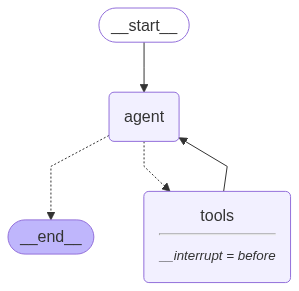

In [ ]:
app

In [ ]:
config = {"configurable": {"thread_id": "2"}}
app.invoke({"messages": "What is 123.456 multiplied by 789.123?"}, config)

{'messages': [HumanMessage(content='What is 123.456 multiplied by 789.123?', additional_kwargs={}, response_metadata={}, id='97b9e01d-df9a-4fa3-a517-17487cbd522a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'GuevsyIur', 'function': {'arguments': '{"x": 123.456, "y": 789.123}', 'name': 'multiply_numbers'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 346, 'total_tokens': 376, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'mistralai/mistral-small-3.2-24b-instruct', 'system_fingerprint': None, 'id': 'gen-1752854183-CkpTLtkNqOFbqMdRUAAw', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--679e4e04-1e73-4c4d-947f-b4a9300bc7ef-0', tool_calls=[{'name': 'multiply_numbers', 'args': {'x': 123.456, 'y': 789.123}, 'id': 'GuevsyIur', 'type': 'tool_call'}], usage_metadata={'input_tokens': 346, 'output_tokens': 30, 'total_tokens': 

In [ ]:
for event in app.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply_numbers (GuevsyIur)
 Call ID: GuevsyIur
  Args:
    x: 123.456
    y: 789.123
================================= Tool Message =================================
Name: multiply_numbers

97421.96908800001
================================== Ai Message ==================================

The product of 123.456 and 789.123 is approximately 97421.969088.
